In [1]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pl.read_csv(R"C:\Users\PC\Desktop\TabPFN-Deep-Dive\data\raw\train.csv")

train_start = 1000
train_end = 5000

test_start = 5000
test_end = 7000

raw_returns = df.select(pl.col("forward_returns")).to_numpy().squeeze()[test_start:test_end]
raw_risk_free = df.select(pl.col("risk_free_rate")).to_numpy().squeeze()[test_start:test_end]

log_returns = np.log1p(raw_returns)
log_risk_free = np.log1p(raw_risk_free)

In [3]:

target = df.select(pl.col("market_forward_excess_returns")).to_numpy().squeeze()

features = None

for col in df.columns:
    if col not in ["date_id", "market_forward_excess_returns", "forward_returns", "risk_free_rate"]:
        feature = df.select(pl.col(col)).to_numpy()
        if features is None:
            features = feature
        else:
            features =  np.hstack((features, feature))

print("X shape:", features.shape)
print("y shape:", target.shape)

X shape: (9021, 94)
y shape: (9021,)


Found existing access token, reusing it for authentication.

Processing: 100%|██████████| [00:08<00:00]


Predictions shape: (2000,)


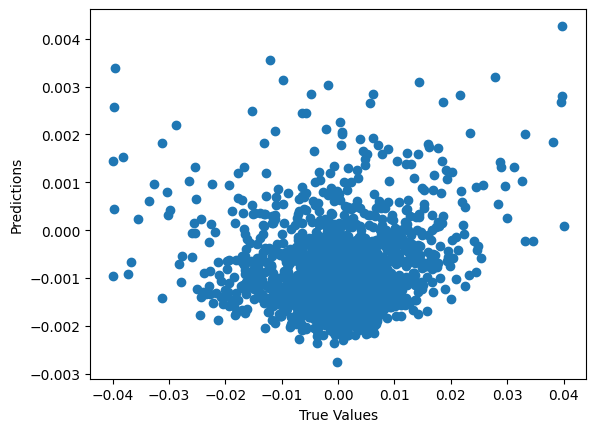

In [4]:
train_targets = target[train_start:train_end]
train_features = features[train_start:train_end]

test_targets = target[test_start:test_end]
test_features = features[test_start:test_end]

from tabpfn_client import TabPFNRegressor
model = TabPFNRegressor()

model.fit(train_features, train_targets)

predictions = model.predict(test_features)
print("Predictions shape:", predictions.shape)

plt.scatter(test_targets, predictions)
plt.xlabel("True Values")  
plt.ylabel("Predictions")
plt.show()

Max score: 0.939402
Best bias:  0.306533
Best scale: 1000.000000


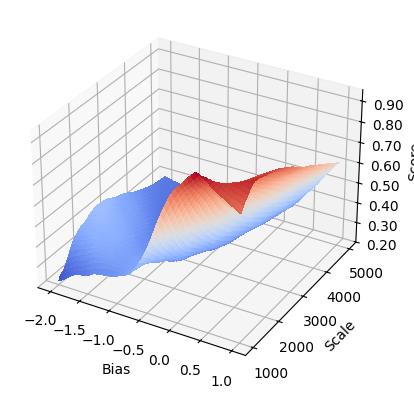

In [9]:
from matplotlib import cm
from private.scoring import calculate_hull_score

def fine_tune_positions(out_of_sample_preds, forward_returns, risk_free_rate):
    # 1D grids of parameters
    B_vals = np.linspace(-2.0, 1.0, 200)     # bias
    S_vals = np.linspace(1000.0, 5000.0, 200)   # scale
    # 2D parameter grid for plotting
    B_grid, S_grid = np.meshgrid(B_vals, S_vals)
    # Score grid (same shape as B_grid / S_grid)
    Score = np.zeros_like(B_grid, dtype=float)

    # Fill the Score grid by looping over parameter combinations
    for i, b in enumerate(B_vals):
        for j, s in enumerate(S_vals):
            strat = 1.0 + (out_of_sample_preds * s) + b
    
            # 2. Clip to legal bounds [0, 2]
            strat[strat > 2.0] = 2.0
            strat[strat < 0.0] = 0.0

            final_score = calculate_hull_score(strat, forward_returns, risk_free_rate)
            Score[j, i] = final_score  # row=j (S), column=i (B)

    # ---- Find the best score and corresponding parameters ----
    max_idx_flat = np.argmax(Score)  # index in flattened array
    j_max, i_max = np.unravel_index(max_idx_flat, Score.shape)
    best_score = Score[j_max, i_max]
    best_bias = B_vals[i_max]
    best_scale = S_vals[j_max]

    print(f"Max score: {best_score:.6f}")
    print(f"Best bias:  {best_bias:.6f}")
    print(f"Best scale: {best_scale:.6f}")

    # Plot
    _ , ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(B_grid, S_grid, Score, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel("Bias")
    ax.set_ylabel("Scale")
    ax.set_zlabel("Score")
    ax.zaxis.set_major_formatter('{x:.02f}')
    plt.show()
    return best_bias, best_scale

best_bias, best_scale = fine_tune_positions(predictions, raw_returns, raw_risk_free)

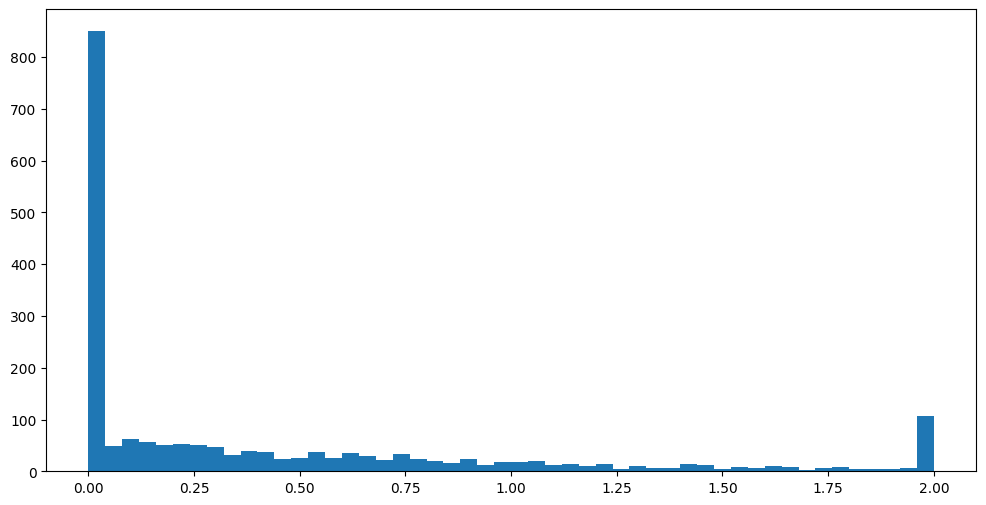

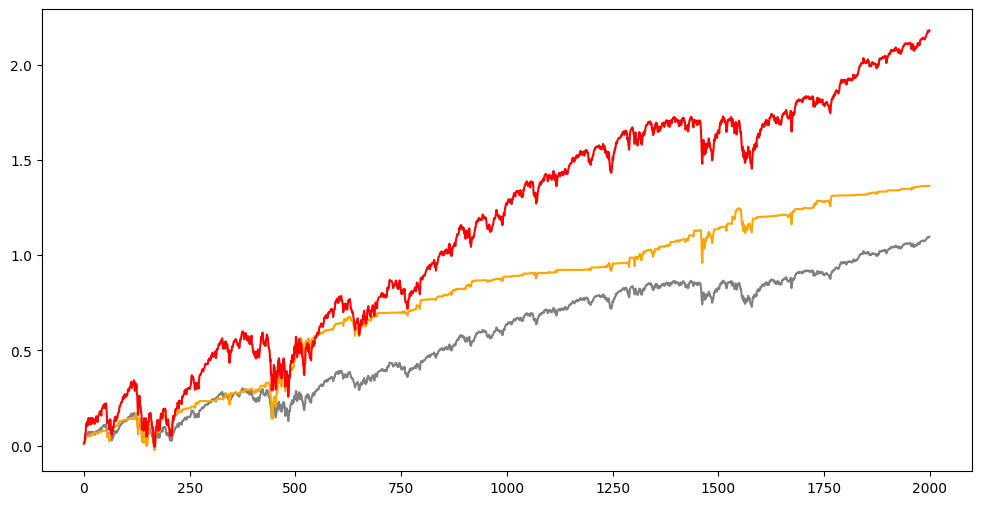

TabPFN-2.5 raw:    Sharpe Ratio 0.939 | Returns 1.363
Constant Position: Sharpe Ratio 0.941 | Returns 1.097
Double Position:   Sharpe Ratio 0.482 | Returns 2.180


In [10]:
positions = ((1.0 + predictions * best_scale) + best_bias).copy()
positions[positions > 2.0] = 2.0
positions[positions < 0.0] = 0.0

plt.figure(figsize=(12, 6))
plt.hist(positions, bins=50)
plt.show()

constant_position = np.ones_like(positions) * 1.0
constant_position_double = np.ones_like(positions) * 2.0

strategy_returns = positions * log_returns + (1.0 - positions) * log_risk_free
double_returns = constant_position_double * log_returns + (1.0 - constant_position_double) * log_risk_free

cum_returns = np.cumsum(log_returns)
cum_strategy_returns = np.cumsum(strategy_returns)
cum_double_returns = np.cumsum(double_returns)

plt.figure(figsize=(12, 6))
plt.plot(cum_returns, color='gray')
plt.plot(cum_strategy_returns, color='orange')
plt.plot(cum_double_returns, color='red')
plt.show()

score = calculate_hull_score(positions, raw_returns, raw_risk_free)
score_constant = calculate_hull_score(constant_position, raw_returns, raw_risk_free)
score_double = calculate_hull_score(constant_position_double, raw_returns, raw_risk_free)
print("TabPFN-2.5 raw:   ", f"Sharpe Ratio {         score:.3f}", "|", f"Returns {cum_strategy_returns[-1]:.3f}")
print("Constant Position:", f"Sharpe Ratio {score_constant:.3f}", "|", f"Returns {         cum_returns[-1]:.3f}")
print("Double Position:  ", f"Sharpe Ratio {  score_double:.3f}", "|", f"Returns {  cum_double_returns[-1]:.3f}")